In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import heapq

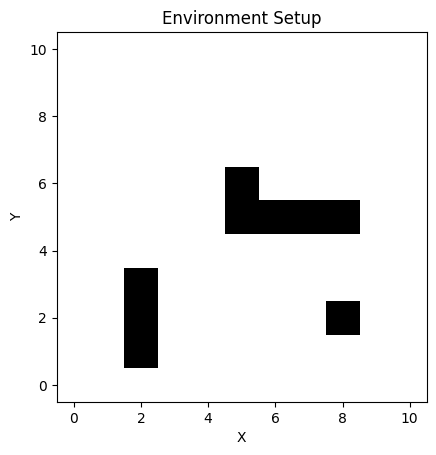

In [ ]:
# Define the grid size and resolution
grid_size = (11, 11)  # 11x11 grid cells
grid = np.zeros(grid_size)  # Initialize grid with free space (0)

# Define obstacles
obstacles = [
    (2, 3, 1, 4),  # (x_start, x_end, y_start, y_end)
    (5, 6, 5, 7),
    (5, 9, 5, 6),
    (8, 9, 2, 3),
]

# Place obstacles on the grid
for (x_start, x_end, y_start, y_end) in obstacles:
    grid[x_start:x_end, y_start:y_end] = 1  # Set obstacle cells to 1

# Visualize the grid
plt.imshow(grid.T, cmap='Greys', origin='lower')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Environment Setup')
plt.show()

In [ ]:
def plot_environment(grid, pathx,pathy):
    plt.imshow(grid.T, cmap='Greys', origin='lower')


    plt.plot(pathx, pathy, marker='o', color='blue')


    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Robot Path Planning')
    plt.show()
# Example usage
#pathx = [0.5, 1, 1, 3, 4, 5, 6, 7, 8, 9]
#pathy = [0.8, 1, 4, 5, 6, 8, 8, 8, 8, 9]
#plot_environment(grid, pathx,pathy)

In [ ]:
def heuristic(current, goal):
    # Euclidean distance heuristic for state (x, y)
    return np.linalg.norm(np.array(current[:2]) - np.array(goal[:2]))

In [ ]:
#checking for collision detection
def is_collision_free(state, grid):
    x, y = int(state[0]), int(state[1])
    if x < 0 or x >= grid.shape[0] or y < 0 or y >= grid.shape[1]:
        return False
    if grid[x, y] == 1:
        return False
    return True


In [ ]:
#kinematic model for the unicycle robot
def kinematic_model(state, control):
    x, y, theta = state
    v, omega = control

    x_next = x + v * np.ceil(np.cos(np.degrees(theta)))
    y_next = y + v * np.ceil(np.sin(np.degrees(theta)))
    theta_next = theta + omega

    return (x_next, y_next, theta_next)

In [ ]:
#modified a* for kinodynamic planning of the unicycle robot
def a_star_kinodynamic(start, goal, grid):
    #making a list of total possible moves by the control vectors
    possible_controls = [(1,0), (1, -np.pi/2), (1, -np.pi/4),(1, np.pi/4)]

    #list of nodes to explore (using min heap to get f-score easily)
    open_heap = []
    #list of explored nodes
    closed_set = set()
    #insert start node open_heap
    heapq.heappush(open_heap, (0, start))
    #dictionary to find way back to start node and make a path
    came_from = {start: None}
    #cost from start to node
    g_score = {start: 0}
    #estimated cost from node to goal
    f_score = {start:heuristic(start,goal)}
    while open_heap:
        #get node with lowest f_score
        current_cost, current = heapq.heappop(open_heap)
        #if current node is goal node trace back path
        if current[:2] == goal[:2]:
            path = []
            while current:
                path.append(current)
                current = came_from[current]
            #path list has the path from end to start need to reverse it
            return path[::-1]
        #current node has been explored, put in closed list to not go back
        closed_set.add(current)

        for control in possible_controls:
            #get next node
            next_state = kinematic_model(current, control)
            if not is_collision_free(next_state, grid):
                continue
            tentative_g_score = g_score[current] + heuristic(current,next_state)
            if tentative_g_score < g_score.get(next_state, float('inf')):
                came_from[next_state] = current
                g_score[next_state] = tentative_g_score
                f_score[next_state] = tentative_g_score + heuristic(next_state, goal)
                heapq.heappush(open_heap, (f_score, next_state))

    return False

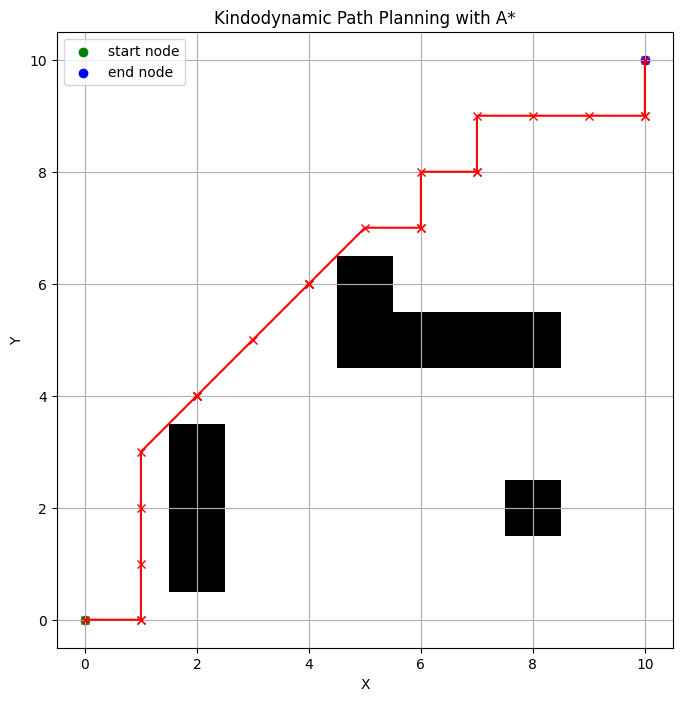

In [ ]:
# Define start and goal positions with orientation (x, y, theta)
start = (0, 0, 0)  # Start at position (0, 0) with orientation 0 radians
goal = (10, 10,0)  # Goal at position (10, 10) with orientation 0 radians


# Find path using A* algorithm
path = a_star_kinodynamic(start, goal, grid)

# Plot the grid with obstacles and the path found
plt.figure(figsize=(8, 8))
plt.imshow(grid.T, cmap='Greys', origin='lower')

if not path:
  print("Path not found")
else:
  # Plot the grid with the path
  path_positions = np.array([pos[:2] for pos in path])
  plt.plot(path_positions[:, 0], path_positions[:, 1], marker='x', color='red')


  plt.scatter(start[0],start[1],marker='o',color='green',label='start node')
  plt.scatter(goal[0],goal[1],marker='o',color='blue',label='end node')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title('Kindodynamic Path Planning with A*')
  plt.legend()
  plt.grid()
  plt.show()


In [ ]:
def prm(start,end,grid,num_samples,neighbors):
  #list of nodes to explore
  samples = [start,end]
  #if length of list is less than total samples +start + end node
  while len(samples)<num_samples+2:
    #randomly choose sample from the grid in range of (0 to 11)
    sample = (np.random.randint(grid.shape[0]), np.random.randint(grid.shape[1]), np.random.randint(grid.shape[1]) * 2 * np.pi)
    #check if it is out of bounds or an obstacle, if true add it to the list of samples
    if is_collision_free(sample,grid):
      samples.append(sample)
      # all samples have been collected, now we make a graph with no edges initially
      # sample:[] for sample in samples - make a dict sample with a key value pair
      # After executing this line, graph is a dictionary where:
      #Each key is a sample (node) from the samples list.
      #Each value is an empty list initially, representing that the node has no outgoing connections (edges) yet.
      graph = {sample:[] for sample in samples}
      #get the distance from a node to all the other nodes and put them in a list distance
      for sample in samples:
            distances=[]
            for other in samples:
                if other != sample:
                    distances.append((heuristic(sample, other), other))
            distances.sort()
            #if the nodes are not out of bound or an obstacle connect them in the graph dict
            #gets the first neighbors elements from the sorted distances list, representing the nearest neighbors.
            for i, neighbor in distances[:neighbors]:
                if is_collision_free(neighbor, grid) and is_collision_free(sample, grid):
                    graph[sample].append(neighbor)
                    graph[neighbor].append(sample)
  #modified a-star function for prm
  def prm_a_star(start, goal, graph):
        open_heap = []
        heapq.heappush(open_heap, (heuristic(start, goal), 0, start))
        came_from = {start: None}
        g_score = {start: 0}
        f_score = {start:heuristic(start,goal)}
        while open_heap:
            i, current_cost, current = heapq.heappop(open_heap)

            if current == goal:
                path = []
                while current:
                    path.append(current)
                    current = came_from[current]
                return path[::-1]

            for neighbor in graph[current]:
                tentative_g_score = current_cost + heuristic(current, neighbor)
                if tentative_g_score < g_score.get(neighbor, float('inf')):
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(open_heap, (f_score, tentative_g_score, neighbor))

        return False

  return prm_a_star(start,goal,graph)


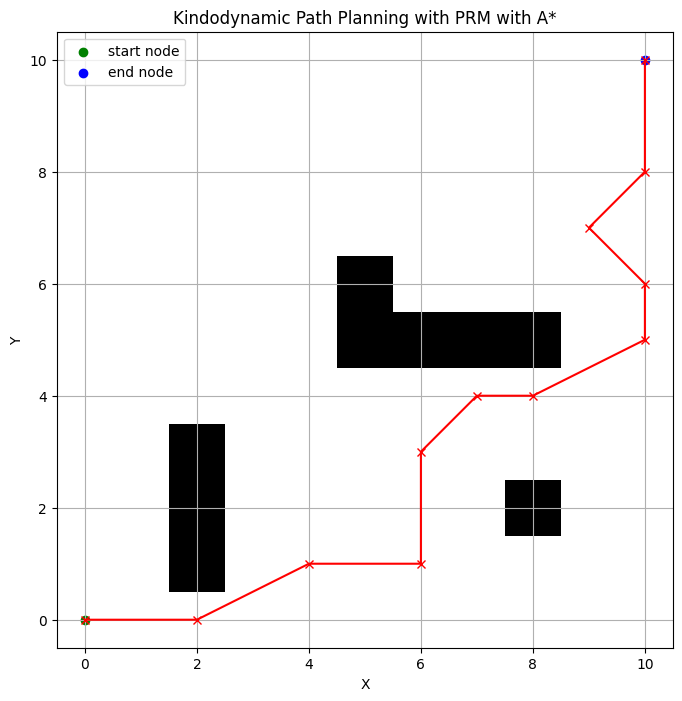

In [ ]:
# Define start and goal positions with orientation (x, y, theta)
start = (0, 0, 0)  # Start at position (0, 0) with orientation 0 radians
goal = (10, 10, 0)  # Goal at position (10, 10) with orientation 45 degrees
#sample and neigher
num_samples = 80
neighbors = 5
# Find path using A* algorithm
path = prm(start, goal, grid,num_samples,neighbors)

# Plot the grid with obstacles and the path found
plt.figure(figsize=(8, 8))
plt.imshow(grid.T, cmap='Greys', origin='lower')

if not path:
  print("Path not found")
else:
  # Plot the grid with the path
  path_positions = np.array([pos[:2] for pos in path])
  plt.plot(path_positions[:, 0], path_positions[:, 1], marker='x', color='red')


  plt.scatter(start[0],start[1],marker='o',color='green',label='start node')
  plt.scatter(goal[0],goal[1],marker='o',color='blue',label='end node')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title('Kindodynamic Path Planning with PRM with A*')
  plt.legend()
  plt.grid()
  plt.show()